In [1]:
# Natural Language Toolkit

!pip install nltk

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Exploratory Data Analysis

Let's begin by loading my Instagram data stored in JSON files. I used the glob module to recursively find all JSON files in a specified directory and its subdirectories.

In [2]:
import os
import glob
import pandas as pd
import json

# set the path to the directory where the JSON files are located
path = "C:/Users/Krish Kabi/Documents/Data Analysis Projects/Instagram Sentiment Analysis/Instagram Data"

# use glob to find all the JSON files in the directory + its subdirectories
json_files = glob.glob(os.path.join(path, '**/*.json'), recursive=True)

In [3]:
# print(json_files)

This sample JSON file titled 'post_comments_1.json' contains my comments on Instagram posts. Let's explore it to understand the structure of data and identify any relevant fields.

In [4]:
# Choose one JSON file for exploration (e.g., 'post_comments_1.json')
sample_file_path = "C:/Users/Krish Kabi/Documents/Data Analysis Projects/Instagram Sentiment Analysis/Instagram Data/your_instagram_activity/comments/post_comments_1.json"

# Load the JSON file
with open(sample_file_path, 'r') as file:
    sample_data = json.load(file)

# Display the first few records
print("Sample Data:")
print(sample_data[:5])

Sample Data:
[{'media_list_data': [{'uri': ''}], 'string_map_data': {'Comment': {'value': 'Haha I rmmbr this ð\x9f\x98\x82ð\x9f\x98\x82'}, 'Media Owner': {'value': 'biggestchaabitothesuccess'}, 'Time': {'timestamp': 1705538403}}}, {'media_list_data': [{'uri': ''}], 'string_map_data': {'Comment': {'value': '.'}, 'Media Owner': {'value': 'pubity'}, 'Time': {'timestamp': 1704272780}}}, {'media_list_data': [{'uri': ''}], 'string_map_data': {'Comment': {'value': 'The gangster life*'}, 'Media Owner': {'value': 'athul.abraham'}, 'Time': {'timestamp': 1704075749}}}, {'media_list_data': [{'uri': ''}], 'string_map_data': {'Comment': {'value': '.'}, 'Media Owner': {'value': 'pubity'}, 'Time': {'timestamp': 1703979970}}}, {'media_list_data': [{'uri': ''}], 'string_map_data': {'Comment': {'value': '.'}, 'Media Owner': {'value': 'pubity'}, 'Time': {'timestamp': 1703910410}}}]


These three JSON files below represent various aspects of my Instagram activity, such as comments, content, and likes. Let's create a function to merge these files into a single Pandas DataFrame, considering the potential variation in file structures.

In [5]:
# Set the path to the directory where the JSON files are located
path = "C:/Users/Krish Kabi/Documents/Data Analysis Projects/Instagram Sentiment Analysis/Instagram Data"

# Define folders of interest
folders_of_interest = [
    'your_instagram_activity/comments/',
    'your_instagram_activity/content/',
    'your_instagram_activity/likes/'
]

# Create an empty list to store dataframes
dfs = []

# Loop through folders and load JSON files
for folder in folders_of_interest:
    folder_path = os.path.join(path, folder)
    json_files = glob.glob(os.path.join(folder_path, '*.json'))
    
    # Loop through JSON files in the folder
    for json_file in json_files:
        with open(json_file, 'r') as file:
            data = json.load(file)
            # You can process or analyze data here if needed
            # For now, let's create a DataFrame for each JSON file
            df = pd.json_normalize(data)
            dfs.append(df)

# Concatenate dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)

# Display the first few records of the merged dataframe
print(merged_df)

    media_list_data string_map_data.Comment.value  \
0     [{'uri': ''}]    Haha I rmmbr this ðð   
1     [{'uri': ''}]                             .   
2     [{'uri': ''}]            The gangster life*   
3     [{'uri': ''}]                             .   
4     [{'uri': ''}]                             .   
..              ...                           ...   
469             NaN                           NaN   
470             NaN                           NaN   
471             NaN                           NaN   
472             NaN                           NaN   
473             NaN                           NaN   

    string_map_data.Media Owner.value  string_map_data.Time.timestamp  \
0           biggestchaabitothesuccess                    1.705538e+09   
1                              pubity                    1.704273e+09   
2                       athul.abraham                    1.704076e+09   
3                              pubity                    1.703980e+09  

Before proceeding with sentiment analysis, we may need to clean the data, handle missing values, and possibly extract relevant features for analysis. Additionally, we can explore specific columns to gain insights into the nature of the Instagram data.

In [6]:
# Display basic information about the DataFrame
merged_df.info()

# Check for missing values in each column
missing_values = merged_df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   media_list_data                    445 non-null    object 
 1   string_map_data.Comment.value      445 non-null    object 
 2   string_map_data.Media Owner.value  343 non-null    object 
 3   string_map_data.Time.timestamp     445 non-null    float64
 4   comments_reels_comments            1 non-null      object 
 5   media                              23 non-null     object 
 6   title                              20 non-null     object 
 7   creation_timestamp                 20 non-null     float64
 8   ig_profile_picture                 1 non-null      object 
 9   ig_reels_media                     1 non-null      object 
 10  ig_stories                         1 non-null      object 
 11  likes_comment_likes                1 non-null      object 

There are missing values in several columns, and some columns have a high percentage of missing values, such as 'comments_reels_comments', 'media', 'title', 'creation_timestamp', 'ig_profile_picture', 'ig_reels_media', 'ig_stories', 'likes_comment_likes', and 'likes_media_likes'.

We'll address these issues by performing the following tasks:

1. Drop columns with a high percentage of missing values: Columns like 'comments_reels_comments', 'media', 'title', 'creation_timestamp', 'ig_profile_picture', 'ig_reels_media', 'ig_stories', 'likes_comment_likes', and 'likes_media_likes' have a high number of missing values and might not provide meaningful insights. We can drop these columns.

2. Handle missing values in remaining columns: For columns like 'string_map_data.Media Owner.value', we can explore the data and decide whether to impute missing values or drop rows with missing values based on the nature of the data.

Let's start with dropping columns and then proceed with further cleaning:

In [7]:
# Drop columns with a high percentage of missing values
columns_to_drop = ['comments_reels_comments', 'media', 'title', 'creation_timestamp', 'ig_profile_picture', 'ig_reels_media', 'ig_stories', 'likes_comment_likes', 'likes_media_likes']
merged_df = merged_df.drop(columns=columns_to_drop)

# Display basic information about the cleaned DataFrame
merged_df.info()

# Check for missing values in the cleaned DataFrame
missing_values = merged_df.isnull().sum()
print("\nMissing Values in Cleaned DataFrame:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   media_list_data                    445 non-null    object 
 1   string_map_data.Comment.value      445 non-null    object 
 2   string_map_data.Media Owner.value  343 non-null    object 
 3   string_map_data.Time.timestamp     445 non-null    float64
dtypes: float64(1), object(3)
memory usage: 14.9+ KB

Missing Values in Cleaned DataFrame:
media_list_data                       29
string_map_data.Comment.value         29
string_map_data.Media Owner.value    131
string_map_data.Time.timestamp        29
dtype: int64


We've successfully dropped columns with a high percentage of missing values. Now, let's proceed with handling the missing values in the remaining columns.

1. 'string_map_data.Media Owner.value': this column represents the media owner so we can choose to impute missing values with a placeholder like "Unknown" or drop rows with missing values based on the importance of this information for sentiment analysis.

2. Other columns: for 'media_list_data', 'string_map_data.Comment.value', and 'string_map_data.Time.timestamp', we can analyze the data distribution and decide whether to impute missing values or drop rows based on the nature of the data.

The 'string_map_data.Media Owner.value' column might be important for sentiment analysis later so let's impute missing values with "Unknown":

In [8]:
# Impute missing values in 'string_map_data.Media Owner.value' with "Unknown"
merged_df['string_map_data.Media Owner.value'].fillna("Unknown", inplace=True)

For the remaining columns, let's carry out the following actions:

- Impute 'media_list_data' with an empty list
- Keep rows with missing 'string_map_data.Comment.value'
- Impute 'string_map_data.Time.timestamp' with the median timestamp

In [9]:
# Impute missing values in 'media_list_data' with an empty list
merged_df['media_list_data'].fillna(value=pd.Series([[]] * len(merged_df)), inplace=True)

# Impute missing values in 'string_map_data.Time.timestamp' with the median timestamp
median_timestamp = merged_df['string_map_data.Time.timestamp'].median()
merged_df['string_map_data.Time.timestamp'].fillna(median_timestamp, inplace=True)

# Impute missing values in 'string_map_data.Comment.value' with "No Comment"
merged_df['string_map_data.Comment.value'].fillna(value="No Comment", inplace=True)

In [10]:
merged_df

,media_list_data,string_map_data.Comment.value,string_map_data.Media Owner.value,string_map_data.Time.timestamp
0,[{'uri': ''}],Haha I rmmbr this ðð,biggestchaabitothesuccess,1.705538e+09
1,[{'uri': ''}],.,pubity,1.704273e+09
2,[{'uri': ''}],The gangster life*,athul.abraham,1.704076e+09
3,[{'uri': ''}],.,pubity,1.703980e+09
4,[{'uri': ''}],.,pubity,1.703910e+09
...,...,...,...,...
469,[],No Comment,Unknown,1.617797e+09
470,[],No Comment,Unknown,1.617797e+09
471,[],No Comment,Unknown,1.617797e+09
472,[],No Comment,Unknown,1.617797e+09


In [11]:
# Check for missing values in the cleaned DataFrame
missing_values = merged_df.isnull().sum()

# Display missing values
print("Missing Values in Cleaned DataFrame:")
print(missing_values)

Missing Values in Cleaned DataFrame:
media_list_data                      0
string_map_data.Comment.value        0
string_map_data.Media Owner.value    0
string_map_data.Time.timestamp       0
dtype: int64


There aren't any missing or null values in the dataset so let's proceed with sentiment analysis.

## Data Pre-processing

For sentiment analysis on Instagram data, we'll use lemmatization. Lemmatization tends to give more meaningful results for social media text, as it reduces words to their base form, considering the context of the entire sentence. It helps in maintaining the semantic meaning of words, which is crucial for sentiment analysis.

### Lemmatization

We'll be using the Natural Language Toolkit (nltk) library for lemmatization. We'll first lemmatize the comment text in the 'string_map_data.Comment.value' column.

In [12]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download the NLTK punkt tokenizer data
nltk.download('punkt')
# Download the WordNet lemmatizer data
nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

# Function to convert the part of speech tag returned by nltk.pos_tag to the WordNet part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN if not recognized

# Function to perform lemmatization on a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization to the 'string_map_data.Comment.value' column
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(lemmatize_sentence)

C:\Users\Krish Kabi\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package punkt to C:\Users\Krish
[nltk_data]     Kabi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Krish
[nltk_data]     Kabi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Krish Kabi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Text Cleaning

Next, we'll perform text cleaning. In this step, we'll remove unnecessary characters, symbols, and numbers from the comments. The goal is to retain only the relevant text that contributes to the sentiment. We'll use the Python re (regular expression) library for this purpose.

In [13]:
import re

# Function to clean text
def clean_text(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply text cleaning to the 'string_map_data.Comment.value' column
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(clean_text)

# Display the first few cleaned records
print("Cleaned Data:")
print(merged_df['string_map_data.Comment.value'])

Cleaned Data:
0      haha i rmmbr this 
1                        
2      the gangster life 
3                        
4                        
              ...        
469            no comment
470            no comment
471            no comment
472            no comment
473            no comment
Name: string_map_data.Comment.value, Length: 474, dtype: object


### Tokenization

Next, we'll perform tokenization. Tokenization involves breaking down the cleaned text into individual words or tokens.

In [14]:
from nltk.tokenize import word_tokenize

# Function for tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply tokenization to the 'string_map_data.Comment.value' column
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(tokenize_text)

# Display the first few tokenized records
print("Tokenized Data:")
print(merged_df['string_map_data.Comment.value'])

Tokenized Data:
0      [haha, i, rmmbr, this]
1                          []
2       [the, gangster, life]
3                          []
4                          []
                ...          
469             [no, comment]
470             [no, comment]
471             [no, comment]
472             [no, comment]
473             [no, comment]
Name: string_map_data.Comment.value, Length: 474, dtype: object


### Stopwords

Now, let's proceed with stopword removal. In NLP, stopwords are words that are common like "the", "and", "is", and often don't contribute much to the meaning of a sentence. Removing them can help reduce dimensionality and improve the efficiency of the analysis.

In [15]:
from nltk.corpus import stopwords

# Download the stopwords if not already downloaded
nltk.download('stopwords')

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Function for stopword removal
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

# Apply stopword removal to the 'string_map_data.Comment.value' column
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(remove_stopwords)

# Display the first few records after stopword removal
print("Data after Stopword Removal:")
print(merged_df['string_map_data.Comment.value'])

Data after Stopword Removal:
0         [haha, rmmbr]
1                    []
2      [gangster, life]
3                    []
4                    []
             ...       
469           [comment]
470           [comment]
471           [comment]
472           [comment]
473           [comment]
Name: string_map_data.Comment.value, Length: 474, dtype: object


[nltk_data] Downloading package stopwords to C:\Users\Krish
[nltk_data]     Kabi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Cloud

Let's generate a word cloud depicting the words in the datafram in different sizes depending on their frequency of use.

In [16]:
!pip install wordcloud

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [17]:
# !pip install --upgrade pip

# !pip install --upgrade Pillow

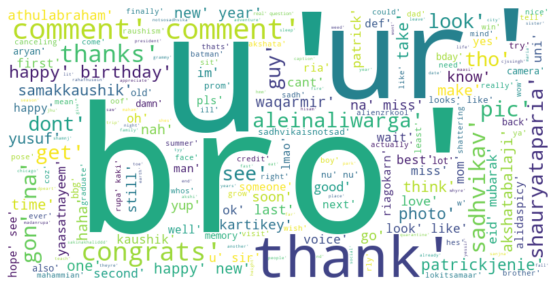

In [18]:
from wordcloud import STOPWORDS
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Concatenate all the comments into a single string
all_comments = ' '.join(merged_df['string_map_data.Comment.value'].astype(str))

# Create and generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_comments)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Vectorization

The last step before moving on to Sentiment Analysis is vectorization. Vectorization converts text data into numerical vectors that can be understood by machine learning models. The approach we'll be using is TF-IDF (Term Frequency-Inverse Document Frequency) or Count Vectorization.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill NaN values with empty lists in the 'string_map_data.Comment.value' column
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(lambda x: [] if pd.isna(x).any() else x)

# Convert lists of words to strings
merged_df['string_map_data.Comment.value'] = merged_df['string_map_data.Comment.value'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['string_map_data.Comment.value'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())

# Display the TF-IDF DataFrame
print(tfidf_df)

     aayushi  accident  act  actress  actually  adilsheikh  adjust  admit  \
0        0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
1        0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
2        0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
3        0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
4        0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
..       ...       ...  ...      ...       ...         ...     ...    ...   
469      0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
470      0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
471      0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
472      0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   
473      0.0       0.0  0.0      0.0       0.0         0.0     0.0    0.0   

     adopted  adventure  ...  youuu  youve  yup  yusuf  yusufs  zach  zehra

## Sentiment Analysis

Let's attempt performing sentiment analysis using TextBlob. TextBlob is built on top of NLTK and provides a simple API for common natural language processing (NLP) tasks such as sentiment analysis.

In [20]:
!pip install textblob

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [21]:
from textblob import TextBlob

# Assuming 'text' is your text data
text = "I love using ChatGPT. It's amazing!"

# Create a TextBlob object
blob = TextBlob(text)

# Get the sentiment polarity (ranges from -1 to 1)
sentiment_polarity = blob.sentiment.polarity

# Label the sentiment based on polarity
if sentiment_polarity > 0:
    sentiment_label = 'positive'
elif sentiment_polarity < 0:
    sentiment_label = 'negative'
else:
    sentiment_label = 'neutral'

print(f"Sentiment: {sentiment_label}")

Sentiment: positive


This will add a new column ('sentiment') to the DataFrame, indicating the sentiment of each comment

In [22]:
comments = merged_df['string_map_data.Comment.value']

# Function to get sentiment polarity using TextBlob
def get_sentiment(comment):
    analysis = TextBlob(comment)
    # Classify the polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis function to each comment
merged_df['sentiment'] = comments.apply(get_sentiment)

# Display the DataFrame with sentiment labels
print(merged_df[['string_map_data.Comment.value', 'sentiment']])

    string_map_data.Comment.value sentiment
0                      haha rmmbr  positive
1                                   neutral
2                   gangster life   neutral
3                                   neutral
4                                   neutral
..                            ...       ...
469                       comment   neutral
470                       comment   neutral
471                       comment   neutral
472                       comment   neutral
473                       comment   neutral

[474 rows x 2 columns]


### Visualization of Sentiments

The next step is to analyze and visualize the sentiment distribution in the Instagram comments. This will provide insights into the overall sentiment of the comments. We'll use matplotlib and seaborn for visualization.

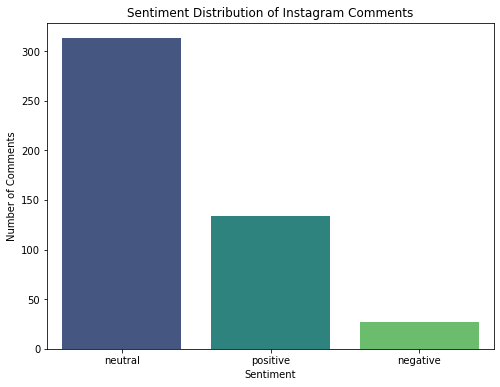

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of comments in each sentiment category
sentiment_counts = merged_df['sentiment'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Sentiment Distribution of Instagram Comments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

### Training & Testing Data

Below is a function that takes care of splitting the data, training the model, fine-tuning, and evaluating its performance. This function will be applied for various classifiers.

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, model, param_grid):
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model with the best parameters
    grid_search.fit(X_train, y_train)

    # Print the best parameters and accuracy
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions on the testing set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return print("Test Accuracy:", accuracy)

### Logistic Regression

We'll attempt this function using Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Vectorized comment data (X) and labeled sentiment column (y)
X = tfidf_df
y = merged_df['sentiment']

# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear']  # Algorithm to use for optimization
}

# Use the function to train and evaluate the model
train_evaluate_model(X, y, logistic_model, param_grid)

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.8335438596491228
Test Accuracy: 0.8842105263157894


C:\Users\Krish Kabi\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Great, we acheived an 88.4% accuracy from the Logistic Regression Model after fine-tuning. Let's attempt a Random Forest Classifier model

### Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Classifier
random_forest_model = RandomForestClassifier()
train_evaluate_model(X, y, random_forest_model, param_grid)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.8177543859649123
Test Accuracy: 0.8421052631578947


### Additional Models

Let's attempt this same procedure with Support Vector Machines (SVM), Gradient Boosting, K-Nearest Neighbors (KNN), and Neural Networks (Multi-Layer Perceptron)

In [27]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Support Vector Machines (SVM)
svm_model = SVC()
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
print("SVM:")
print(train_evaluate_model(X, y, svm_model, svm_param_grid))

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
print("\nGradient Boosting:")
print(train_evaluate_model(X, y, gb_model, gb_param_grid))

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
print("\nKNN:")
print(train_evaluate_model(X, y, knn_model, knn_param_grid))

# Neural Networks (Multi-Layer Perceptron)
mlp_model = MLPClassifier()
mlp_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]}
print("\nNeural Networks (MLP):")
print(train_evaluate_model(X, y, mlp_model, mlp_param_grid))

SVM:
Best Parameters: {'C': 10, 'kernel': 'linear'}
Best Accuracy: 0.7834736842105263
Test Accuracy: 0.8210526315789474
None

Gradient Boosting:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best Accuracy: 0.8415087719298245
Test Accuracy: 0.8736842105263158
None

KNN:
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.7070877192982457
Test Accuracy: 0.7157894736842105
None

Neural Networks (MLP):
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
Best Accuracy: 0.7808771929824562
Test Accuracy: 0.7684210526315789
None


C:\Users\Krish Kabi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


As we can see, the other models didn't perform as well compared to Logistic Regression, however, the Gradient Boosting algorithm did achieve a slightly better accuracy when compared to Random Forest.

## Prediction Testing

In [28]:
# Function for preprocessing text
def preprocess_text(text):
    # Text cleaning: Remove special characters, links, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+|\d+|\b\w\b', '', text, flags=re.M)

    # Tokenization
    words = nltk.word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lemmatized_words if word.lower() not in stop_words]

    # Convert the list of words back to a string
    preprocessed_text = ' '.join(filtered_words)

    return preprocessed_text

In [29]:
# Sample sentence
sample_sentence = "I don't quite like this"
preprocessed_sentence = preprocess_text(sample_sentence)

# Vectorize the preprocessed sentence using the trained TF-IDF vectorizer
vectorized_sentence = tfidf_vectorizer.transform([preprocessed_sentence])

# Initialize the Logistic Regression model with the best parameters from above
logistic_model = LogisticRegression(C=100, penalty='l1', solver='liblinear')

# Fit the model (not necessary for prediction, but done for clarity)
logistic_model.fit(X, y)

# Make predictions using the Logistic Regression model
prediction = logistic_model.predict(vectorized_sentence)

# Print the predicted sentiment
print("Predicted Sentiment:", prediction[0])

Predicted Sentiment: negative


## Cross-Validation

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline

# Vectorized comment data (X) and labeled sentiment column (y)
X = merged_df['string_map_data.Comment.value']
y = merged_df['sentiment']

# Create a pipeline with TF-IDF vectorization and Logistic Regression
model = make_pipeline(
    TfidfVectorizer(max_features=1000),
    LogisticRegression(C=100, penalty='l1', solver='liblinear')
)

# Use stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores
accuracy_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the accuracy scores for each fold
print("Cross-Validation Accuracy Scores:")
for fold, accuracy in enumerate(accuracy_scores, start=1):
    print(f"Fold {fold}: {accuracy:.4f}")

# Print the average accuracy across all folds
print(f"\nAverage Accuracy: {accuracy_scores.mean():.4f}")

Cross-Validation Accuracy Scores:
Fold 1: 0.8842
Fold 2: 0.8842
Fold 3: 0.8526
Fold 4: 0.7579
Fold 5: 0.8617

Average Accuracy: 0.8481


C:\Users\Krish Kabi\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Conclusion

In this project, I successfully conducted sentiment analysis on my Instagram data using NLP techniques and various machine learning models. The primary goal was to predict sentiment labels (positive, negative, or neutral) based on the content of Instagram comments.

Recommendations for Future Refinement:

1. Explore Deep Learning Models:

Investigate the use of more complex models, such as deep learning architectures (e.g., recurrent neural networks or transformers) for potential improvements in capturing nuanced sentiments.

2. Ensemble Methods:

Experiment with ensemble methods like Random Forests or stacking multiple models to further enhance predictive performance.

3. Data Augmentation:

Augment the dataset by collecting more Instagram data or incorporating external datasets to improve model robustness and diversity.

4. Fine-Tune Preprocessing:

Continuously refine text preprocessing steps, including experimenting with different lemmatization techniques, stopwords, and text cleaning methods.

5. Continuous Monitoring:

Monitor model performance over time and retrain it periodically with new data to ensure its relevancy and effectiveness.


Overall, this sentiment analysis project has provided valuable insights into the sentiment dynamics of my Instagram data. As I move forward, implementing these recommendations will contribute to the ongoing refinement and optimization of the sentiment analysis model.